In [1]:
# !git clone https://github.com/ayushexploring/track-data

!git clone https://github.com/Promisery/track
!7za x track/IMG.zip

import shutil
shutil.move('IMG','track/IMG')

!ls track


fatal: destination path 'track' already exists and is not an empty directory.

7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 4333321 bytes (4232 KiB)

Extracting archive: track/IMG.zip
 20% 4096 Open              --
Path = track/IMG.zip
Type = zip
Physical Size = 4333321
Embedded Stub Size = 4
Total Physical Size = 266477321
Multivolume = +
Volume Index = 5
Volumes = 6

  0%      2% 458 - IMG/center_2020_02_05_13_58_16_365.jpg                                                   4% 885 - IMG/center_2020_02_05_13_59_02_040.jpg                                                 

In [2]:
!pip3 install imgaug
# !pip uninstall tensorflow
!pip install --upgrade tensorflow

import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import cv2
import pandas as pd
import ntpath
import random

keras.backend.backend()

Requirement already up-to-date: tensorflow in /usr/local/lib/python3.6/dist-packages (2.1.0)


Using TensorFlow backend.


2.1.0


'tensorflow'

total data: 6631
removed: 3537
remaining: 3094
center      center_2020_02_05_13_57_29_212.jpg
left        left_2020_02_05_13_57_29_212.jpg  
right       right_2020_02_05_13_57_29_212.jpg 
steering   -0.161281                          
throttle    1                                 
reverse     0                                 
speed       2.91812                           
Name: 7, dtype: object
Training Samples: 7425
Valid Samples: 1857


Text(0.5, 1.0, 'Validation set')

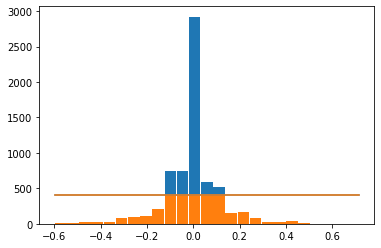

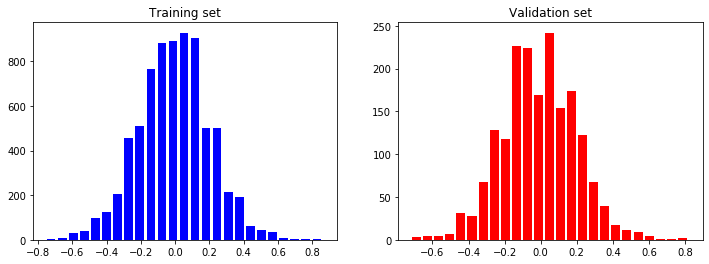

In [3]:
datadir = 'track'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names=columns)
pd.set_option('display.max_colwidth', -1)
data.head()


def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail


data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()
num_bins = 25
samples_per_bin = 400
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1] + bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))
print('total data:', len(data))
remove_list = []
for j in range(num_bins):
    list_ = []
    for i in range(len(data['steering'])):
        if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j + 1]:
            list_.append(i)
    list_ = shuffle(list_)
    list_ = list_[samples_per_bin:]
    remove_list.extend(list_)

print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining:', len(data))

hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

print(data.iloc[1])


def load_img_steering(datadir, df):
    image_path = []
    steering = []
    for i in range(len(data)):
        indexed_data = data.iloc[i]
        center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
        image_path.append(os.path.join(datadir, center.strip()))
        steering.append(float(indexed_data[3]))
        # left image append
        image_path.append(os.path.join(datadir, left.strip()))
        steering.append(float(indexed_data[3]) + 0.15)
        # right image append
        image_path.append(os.path.join(datadir, right.strip()))
        steering.append(float(indexed_data[3]) - 0.15)
    image_paths = np.asarray(image_path)
    steerings = np.asarray(steering)
    return image_paths, steerings


image_paths, steerings = load_img_steering(datadir + '/IMG', data)
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

Text(0.5, 1, 'Flipped Image - Steering Angle:0.20687941999999998')

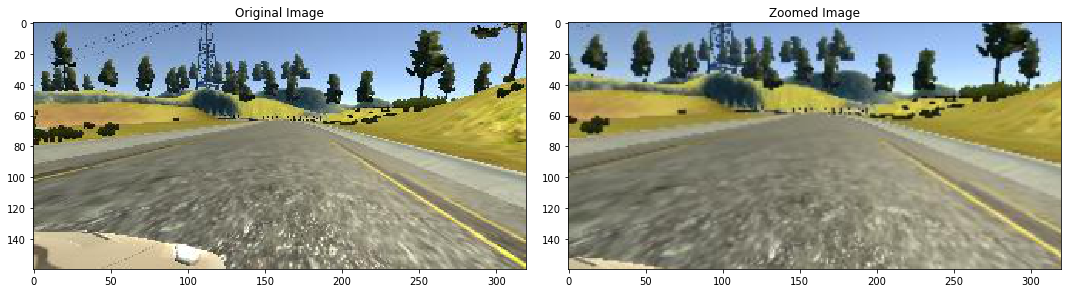

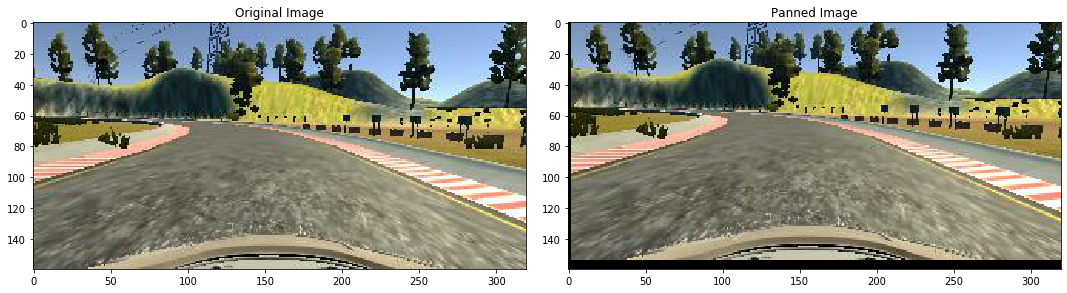

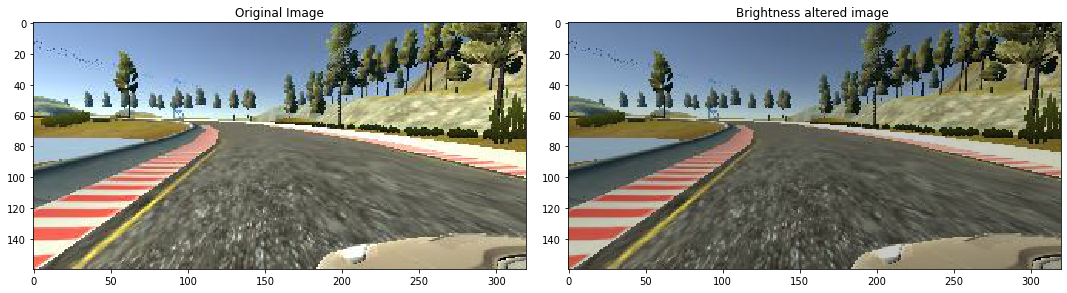

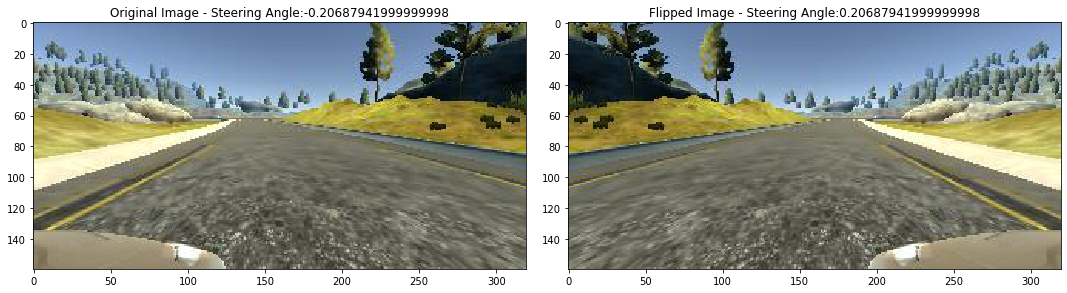

In [4]:





def zoom(image):
    zoom = iaa.Affine(scale=(1, 1.3))
    image = zoom.augment_image(image)
    return image


image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')

axs[1].imshow(zoomed_image)
axs[1].set_title('Zoomed Image')


def pan(image):
    pan = iaa.Affine(translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)})
    image = pan.augment_image(image)
    return image


image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
panned_image = pan(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')

axs[1].imshow(panned_image)
axs[1].set_title('Panned Image')


def img_random_brightness(image):
    brightness = iaa.Multiply((0.2, 1.2))
    image = brightness.augment_image(image)
    return image


image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
brightness_altered_image = img_random_brightness(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')

axs[1].imshow(brightness_altered_image)
axs[1].set_title('Brightness altered image ')


def img_random_flip(image, steering_angle):
    image = cv2.flip(image, 1)
    steering_angle = -steering_angle
    return image, steering_angle


random_index = random.randint(0, 1000)
image = image_paths[random_index]
steering_angle = steerings[random_index]

original_image = mpimg.imread(image)
flipped_image, flipped_steering_angle = img_random_flip(original_image, steering_angle)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image - ' + 'Steering Angle:' + str(steering_angle))

axs[1].imshow(flipped_image)
axs[1].set_title('Flipped Image - ' + 'Steering Angle:' + str(flipped_steering_angle))

In [5]:



def random_augment(image, steering_angle):
    image = mpimg.imread(image)
    if np.random.rand() < 0.5:
        image = pan(image)
    if np.random.rand() < 0.5:
        image = zoom(image)
    if np.random.rand() < 0.5:
        image = img_random_brightness(image)
    if np.random.rand() < 0.5:
        image, steering_angle = img_random_flip(image, steering_angle)

    return image, steering_angle


ncol = 2
nrow = 10

fig, axs = plt.subplots(nrow, ncol, figsize=(15, 50))
fig.tight_layout()

for i in range(10):
    randnum = random.randint(0, len(image_paths) - 1)
    random_image = image_paths[randnum]
    random_steering = steerings[randnum]

    original_image = mpimg.imread(random_image)
    augmented_image, steering = random_augment(random_image, random_steering)

    axs[i][0].imshow(original_image)
    axs[i][0].set_title("Original Image")

    axs[i][1].imshow(augmented_image)
    axs[i][1].set_title("Augmented Image")


def img_preprocess(img):
    img = img[60:135, :, :]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img, (3, 3), 0)
    img = cv2.resize(img, (200, 66))
    img = img / 255
    return img


image = image_paths[100]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed Image')

Output hidden; open in https://colab.research.google.com to view.

Text(0.5, 1, 'Validation Image')

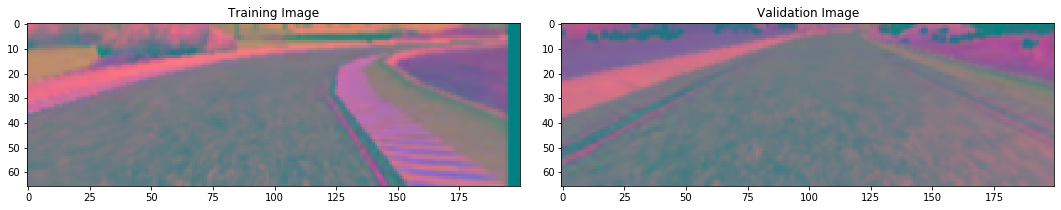

In [6]:


def batch_generator(image_paths, steering_ang, batch_size, istraining):
    while True:
        batch_img = []
        batch_steering = []

        for i in range(batch_size):
            random_index = random.randint(0, len(image_paths) - 1)

            if istraining:
                im, steering = random_augment(image_paths[random_index], steering_ang[random_index])

            else:
                im = mpimg.imread(image_paths[random_index])
                steering = steering_ang[random_index]

            im = img_preprocess(im)
            batch_img.append(im)
            batch_steering.append(steering)
        yield (np.asarray(batch_img), np.asarray(batch_steering))


x_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1))
x_valid_gen, y_valid_gen = next(batch_generator(X_valid, y_valid, 1, 0))

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(x_train_gen[0])
axs[0].set_title('Training Image')

axs[1].imshow(x_valid_gen[0])
axs[1].set_title('Validation Image')


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               1

Text(0.5, 0, 'Epoch')

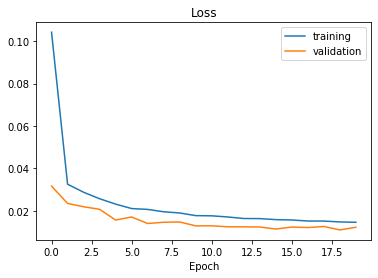

In [7]:



def nvidia_model():
    model = Sequential()
    model.add(Conv2D(24, (5, 5), strides=(2, 2), input_shape=(66, 200, 3), activation='elu'))
    model.add(Conv2D(36, (5, 5), strides=(2, 2), activation='elu'))
    model.add(Conv2D(48, (5, 5), strides=(2, 2), activation='elu'))
    model.add(Conv2D(64, (3, 3), activation='elu'))

    model.add(Conv2D(64, (3, 3), activation='elu'))
    #   model.add(Dropout(0.5))

    model.add(Flatten())

    model.add(Dense(100, activation='elu'))
    #   model.add(Dropout(0.5))

    model.add(Dense(50, activation='elu'))
    #   model.add(Dropout(0.5))

    model.add(Dense(10, activation='elu'))
    #   model.add(Dropout(0.5))

    model.add(Dense(1))

    optimizer = Adam(lr=1e-3)
    model.compile(loss='mse', optimizer=optimizer)
    return model


model = nvidia_model()
print(model.summary())



model.save('test.h5', save_format='h5')

history = model.fit_generator(batch_generator(X_train, y_train, 100, 1),
                              steps_per_epoch=300,
                              epochs=20,
                              validation_data=batch_generator(X_valid, y_valid, 100, 0),
                              validation_steps=200,
                              verbose=1,
                              shuffle=1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')



In [8]:
from google.colab import drive
mount_folder = "/content/gdrive"
drive.mount(mount_folder, force_remount=True)
import os

app_folder = mount_folder + '/My Drive'
os.chdir(app_folder)

model.save('model.h5', save_format='h5')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
